Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [94]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Calculating TopN file extensions in Git repos from public Github Dataset

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_frequent_items_sketches_demo.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fbigquery-utils%2Fmaster%2Fnotebooks%2bigquery_frequent_items_sketches_demo.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_frequent_items_sketches_demo.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/bigquery/v1/32px.svg" alt="BigQuery Studio logo"><br> Open in BigQuery Studio
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/bigquery-utils/blob/master/notebooks/bigquery_frequent_items_sketches_demo.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>    

<div style="clear: both;"></div>

| | |
|-|-|
| Author |  [Nikunj Bhartia](https://github.com/nikunjbhartia)

# Demo Overview
- Data prep
- Frequent Items (FI) Sketch Creation
   - Using BQ JS UDAF
   - The JS UD(A)Fs are loaded with OSS Datasketch FI sketch cpp library compiled to webassembly and published in all regional BQ public datasets
- Extracting TopN file extensions :
  1. Exact using `GROUP BY` & `COUNT()`
  2. Approx, with FI sketch support, using BQ JS UDAF

- Compare Results
- Compare query stats


# Setup

In [95]:
#@title Provide Google Credentials to Colab Runtime (May Require Manually Copy/Pasting Authentication Code)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [96]:
#@title Enter Google Cloud/BigQuery Project ID for demo
project_id = '' #@param{type:"string"}

# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [97]:
#@title Function to plot query stats comparision charts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

def plot_query_metrics(df, prefix_list):
    # Filter dataframe based on query_tag prefixes
    filtered_df = df[df['query_tag'].str.startswith(tuple(prefix_list))]

    # Create figure with 3 subplots in a single row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # Increased width to stretch horizontally

    # Define bar width and positions
    bar_width = 0.5  # Width of each bar
    bar_positions = np.arange(len(filtered_df['query_tag']))  # Positions for bars (e.g., [0, 1])

    # Dynamically generate color_map based on prefix_list
    # Use a color palette (e.g., tab10 has 10 distinct colors)
    # https://matplotlib.org/stable/users/explain/colors/colormaps.html#qualitative
    color_palette = plt.cm.tab10(np.linspace(0, 1, len(prefix_list)))  # Generate colors for each prefix
    color_map = {prefix: color_palette[i] for i, prefix in enumerate(prefix_list)}

    # Create colors list using prefix match
    colors = [color_map[next(key for key in color_map.keys() if tag.startswith(key))]
              for tag in filtered_df['query_tag']]

    # Plot 1: Total Slot Seconds
    bars1 = ax1.bar(bar_positions, filtered_df['total_slot_sec'], color=colors, width=bar_width,
                    label=filtered_df['query_tag'])  # Add labels for legend
    ax1.set_yscale('log')  # Use logarithmic scale for y-axis
    ax1.set_title('Total Slot Seconds by Query Tag')
    ax1.set_ylabel('Slot Seconds')
    ax1.set_xticks([])  # Remove x-axis ticks
    ax1.set_xticklabels([])  # Remove x-axis labels
    ax1.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    # Add exact values on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_slot_sec = max(filtered_df['total_slot_sec'])
    ax1.set_ylim(top=max_slot_sec * 2)  # Double the max value to create headroom

    # Plot 2: Total Execution Time in Seconds
    bars2 = ax2.bar(bar_positions, filtered_df['total_time_sec'], color=colors, width=bar_width,
                    label=filtered_df['query_tag'])  # Add labels for legend
    ax2.set_yscale('log')  # Use logarithmic scale for y-axis
    ax2.set_title('Total Execution Time by Query Tag')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xticks([])  # Remove x-axis ticks
    ax2.set_xticklabels([])  # Remove x-axis labels
    ax2.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    # Add exact values on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_time_sec = max(filtered_df['total_time_sec'])
    ax2.set_ylim(top=max_time_sec * 2)  # Double the max value to create headroom

    # Plot 3: Total MB Processed
    bars3 = ax3.bar(bar_positions, filtered_df['total_MB_processed'], color=colors, width=bar_width,
                    label=filtered_df['query_tag'])  # Add labels for legend
    ax3.set_yscale('log')  # Use logarithmic scale for y-axis
    ax3.set_title('Total MB Processed by Query Tag')
    ax3.set_ylabel('MB Processed')
    ax3.set_xticks([])  # Remove x-axis ticks
    ax3.set_xticklabels([])  # Remove x-axis labels
    ax3.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks on log scale
    # Add exact values on bars
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width() / 2, height * 1.1,  # 1.1 for slight offset above bar
                 f'{height:.2f}', ha='center', va='bottom')
    # Increase y-axis limit to create space for text
    max_mb_processed = max(filtered_df['total_MB_processed'])
    ax3.set_ylim(top=max_mb_processed * 2)  # Double the max value to create headroom

    # Add a single legend for the entire figure with increased font size
    legend_font = FontProperties(size=12)  # Increase legend font size to 12
    fig.legend(bars1, filtered_df['query_tag'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05),
               prop=legend_font)

    # Adjust layout to center-align charts and reduce uneven white space
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.02, wspace=0.3)
    # left=0.05 and right=0.95 ensure the charts stretch to nearly the full width
    # top=0.85 and bottom=0.02 reduce excess space at the top and accommodate the legend
    # wspace=0.3 maintains the spacing between subplots

    # Display the plots
    plt.show()

# Data Prep

In [98]:
# Creating demo dataset in given project
output_dataset_id = 'datasketch_demo_us'
dataset_location = 'us'

# Combine project and dataset
dataset_id = f"{bq_client.project}.{output_dataset_id}"
dataset = bigquery.Dataset(dataset_id)
dataset.location = dataset_location

# Check to make sure output dataset exists, create it if not
try:
  bq_client.get_dataset(dataset_id)
  print(f"BigQuery dataset {dataset_id} exists\n")

except:
  print(f"BigQuery dataset {dataset_id} doesn't exist, so creating it\n")
  dataset = bq_client.create_dataset(dataset)
  print(f"BigQuery dataset {dataset_id} created in {dataset_location}")

BigQuery dataset nikunjbhartia-test-clients.datasketch_demo_us exists



In [99]:
#@title Public Data preview
%%bigquery --project {project_id}
SELECT *
FROM `bigquery-public-data.github_repos.files`
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,ref,path,mode,id,symlink_target
0,klml/drfrederson,refs/heads/master,_drf/lib/spyc,57344,5cbaa0af30b499a9a741a08b84970208bcf65c42,None
1,klml/drfrederson,refs/heads/master,_drf/lib/mustache,57344,14bc3b4f6a4770b535fc433bfd0435471ed386c6,None
2,bmmchugh/core,refs/heads/master,rake/vendor/java_build_task,57344,4c01e40dee2ec65e19d5a653def66ce93faf1aac,None
3,TelerikAcademy/Data-Structures-and-Algorithms,refs/heads/master,Workshops/2016/23-11-2016/Pattern/SVGs/1_color...,40960,129ce1f294fb80f18e1e6d37c161d9826992be38,1.svg
4,rwinch/sagan,refs/heads/master,wiki,57344,f9e464069a242975768a8f2b13db4098f731feee,None
5,wojciiii/RapidBreeze,refs/heads/master,src/uml/plantuml.jar,40960,6e3dc4e0a976b3495ccc03b98c219ff21ed87e97,plantuml.7999.jar
6,wscqs/QSWB,refs/heads/master,DSWeibo/Pods/Headers/Private/SDWebImage/NSData...,40960,84574987a6526177d1e2c01148f61d15c6834270,../../../SDWebImage/SDWebImage/NSData+ImageCon...
7,wscqs/QSWB,refs/heads/master,DSWeibo/Pods/Headers/Private/AFNetworking/UIBu...,40960,8f2e221939a886ccf4fb7386c447f5dffcc00fec,../../../AFNetworking/UIKit+AFNetworking/UIBut...
8,wscqs/QSWB,refs/heads/master,DSWeibo/Pods/Headers/Private/AFNetworking/AFUR...,40960,d9b35fb754fdebac32eaf763ed331f28eea1e4d9,../../../AFNetworking/AFNetworking/AFURLConnec...
9,wscqs/QSWB,refs/heads/master,DSWeibo/Pods/Headers/Private/AFNetworking/UIIm...,40960,74f66499094512646cb2efc69ae8e207fba37467,../../../AFNetworking/UIKit+AFNetworking/UIIma...


In [100]:
#@title Public data number of records
%%bigquery --project {project_id}
-- Verify the row count.
SELECT COUNT(*) AS row_count
FROM `bigquery-public-data.github_repos.files`;

Query is running:   0%|          |

Downloading:   0%|          |

,row_count
0,2309424945


# Exact Metric Extraction

In [101]:
#@title Query to extract file count for top 10 file extensions in all github repos using `GROUP BY` and `LIMIT`
%%bigquery --no_query_cache exact_top_10_extensions_df --project {project_id}
/* QUERY_TAG<(01) EXACT using GROUP BY & COUNT > */
SELECT
  REGEXP_EXTRACT(path, r'\.([^.]+)$') AS file_extension,
  COUNT(*) as file_count
FROM `bigquery-public-data.github_repos.files`
GROUP BY file_extension
HAVING file_extension IS NOT NULL
ORDER BY file_count DESC
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

In [102]:
exact_top_10_extensions_df

,file_extension,file_count
0,png,432540779
1,js,287564161
2,c,266309899
3,h,246919509
4,php,92049161
5,java,59475340
6,txt,52420600
7,html,47835975
8,json,42702526
9,svg,41563549


# FI Sketch Creation


### OSS FI Sketch Creation using BQ JS UDAF

[datasketches-bigquery github](https://github.com/apache/datasketches-bigquery/blob/main/fi/README.md)

[FI sketch relative error](https://datasketches.apache.org/docs/Frequency/FrequentItemsErrorTable.html)

In [103]:
#@title Query to create git file extension based FI sketches for each git-repo
%%bigquery --project {project_id}
/* QUERY_TAG<(03) CREATE_FI_SKETCHES_ALL> */
CREATE OR REPLACE TABLE `datasketch_demo_us.fi_sketches_per_repo` AS
SELECT
  repo_name,
  bqutil.datasketches.frequent_strings_sketch_build(
    REGEXP_EXTRACT(path, r'\.([^.]+)$'),
    1,
    8) AS extensions_fi_sketch,
FROM `bigquery-public-data.github_repos.files`
GROUP BY repo_name

Query is running:   0%|          |

""


In [104]:


#@title Query to create FI sketch for a single repo ( just to compare stats for incremental sketch creation )
%%bigquery --project {project_id}
/* QUERY_TAG<(04) CREATE_FI_SKETCHES_1Repo> */
SELECT
  repo_name,
  bqutil.datasketches.frequent_strings_sketch_build(
    REGEXP_EXTRACT(path, r'\.([^.]+)$'),
    1,
    8) AS extensions_fi_sketch,
FROM `bigquery-public-data.github_repos.files`
WHERE repo_name = "google/mysql-protobuf"
GROUP BY repo_name

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,extensions_fi_sketch
0,google/mysql-protobuf,b'\x04\x01\n\x08\x08\x00\x00\x00\x88\x00\x00\x...


In [105]:
# Sample output of sketches table
%%bigquery --project {project_id}
SELECT *
from `datasketch_demo_us.fi_sketches_per_repo`
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,extensions_fi_sketch
0,sh0b/ejabberd-zimbra,b'\x01\x01\n\x08\x03\x05\x00\x00'
1,FrankHliva/IncludeJS,b'\x01\x01\n\x08\x03\x05\x00\x00'
2,kammag/wot,b'\x01\x01\n\x08\x03\x05\x00\x00'
3,spar1/spar1,b'\x01\x01\n\x08\x03\x05\x00\x00'
4,otakisan/DiffCost,b'\x01\x01\n\x08\x03\x05\x00\x00'
5,spexiono/Stylish-Spotify,b'\x01\x01\n\x08\x03\x05\x00\x00'
6,AdamByrne/cloak.js,b'\x01\x01\n\x08\x03\x05\x00\x00'
7,exsules/docker-postgres,b'\x01\x01\n\x08\x03\x05\x00\x00'
8,HugoDecharnes/CPU,b'\x01\x01\n\x08\x03\x05\x00\x00'
9,Juciane/URI,b'\x01\x01\n\x08\x03\x05\x00\x00'


# Approx Metric Extraction

See all supported FI sketch functions in [datasketches-bigquery repo](https://github.com/apache/datasketches-bigquery/blob/main/fi/README.md)

- All these functions are published in all regional BQ public datasets : `bqutil.datasketches` (US multiregion) or `bqutil.datasketches_<region>`
- See [bigquery-utils repo](https://github.com/GoogleCloudPlatform/bigquery-utils/tree/master/udfs#repo-folder-to-bigquery-dataset-mappings) for more details

In [106]:
#@title Query to extract file counts for Top10 file extensions in github using fi sketch BQ UD(A)Fs
%%bigquery approx_top_10_extensions_df --project {project_id}

/* QUERY_TAG<(02) APPROX using FI_SKETCHES > */
SELECT
  fi.item as file_extension,
  fi.estimate as file_count
FROM (
  SELECT
    bqutil.datasketches.frequent_strings_sketch_get_result(
      bqutil.datasketches.frequent_strings_sketch_merge(extensions_fi_sketch, 8),
      "NO_FALSE_NEGATIVES",
      null) as frequent_items
  FROM `datasketch_demo_us.fi_sketches_per_repo`), UNNEST(frequent_items) as fi
ORDER BY file_count DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

# Comparing results

In [107]:
approx_top_10_extensions_df

,file_extension,file_count
0,png,432569470
1,js,287608650
2,c,266333125
3,h,246946220
4,php,92146973
5,java,59540270
6,txt,52432375
7,html,47859376
8,json,42748551
9,svg,41619467


In [108]:
exact_top_10_extensions_df

,file_extension,file_count
0,png,432540779
1,js,287564161
2,c,266309899
3,h,246919509
4,php,92049161
5,java,59475340
6,txt,52420600
7,html,47835975
8,json,42702526
9,svg,41563549


In [109]:
# Comparing file counts from topN extensions from both methods

approx_top_10_extensions_df_2 = approx_top_10_extensions_df.rename(columns={'file_count': 'approx_file_count'})
exact_top_10_extensions_df_2 = exact_top_10_extensions_df.rename(columns={'file_count': 'exact_file_count'})

# Merge the DataFrames.
comparision_df = exact_top_10_extensions_df_2.merge(approx_top_10_extensions_df_2, on=['file_extension'], how='outer')
comparision_df.sort_values(by='exact_file_count', ascending=False)

,file_extension,exact_file_count,approx_file_count
7,png,432540779,432569470
4,js,287564161,287608650
0,c,266309899,266333125
1,h,246919509,246946220
6,php,92049161,92146973
3,java,59475340,59540270
9,txt,52420600,52432375
2,html,47835975,47859376
5,json,42702526,42748551
8,svg,41563549,41619467


# Comparing Query Stats

This compares query stats like slot_sec, total query runtime, memory scanned etc for all the relevant queries above identified by query tags embedded in each sql query.

In [110]:
%%bigquery stats_df --project {project_id}
DECLARE CURRENT_DT DATE DEFAULT CURRENT_DATE();

SELECT
  query_tag,
  total_time_sec,
  total_slot_sec,
  total_MB_processed,
  shuffle_output_MB,
  cache_hit,
  creation_time
FROM (
  SELECT *
  FROM (
    SELECT
      REGEXP_EXTRACT(query, r'/\* QUERY_TAG<(.*?)> \*/') AS query_tag,
      (TIMESTAMP_DIFF(end_time, start_time, MILLISECOND)/1000) as total_time_sec,
      (total_slot_ms/1000) as total_slot_sec,
      (total_bytes_processed/pow(1024,2)) AS total_MB_processed,
      (SELECT SUM(stage.shuffle_output_bytes) FROM UNNEST(job_stages) stage)/pow(1024,2) AS shuffle_output_MB,
      cache_hit,
      creation_time
    FROM `region-us`.INFORMATION_SCHEMA.JOBS_BY_PROJECT
    WHERE state='DONE'
    AND DATE(creation_time) = CURRENT_DT
    AND creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 5 MINUTE) AND CURRENT_TIMESTAMP()
    AND query LIKE "%QUERY_TAG%")
  WHERE query_tag IS NOT NULL
  QUALIFY ROW_NUMBER() OVER (PARTITION BY query_tag ORDER BY creation_time DESC) = 1)
ORDER BY query_tag ASC;


Query is running:   0%|          |

Downloading:   0%|          |

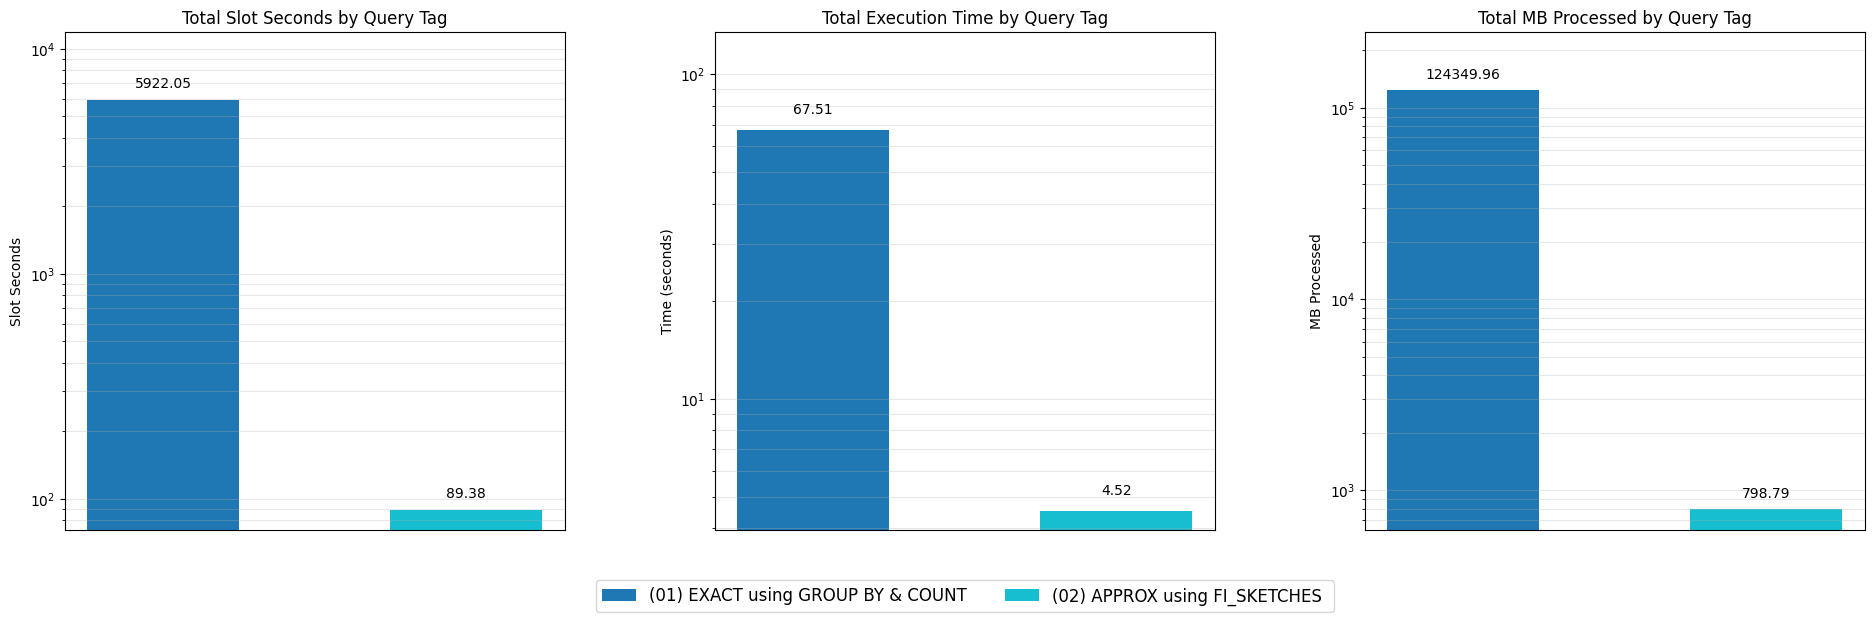

In [111]:
#@title Plot charts for comparing exact and approx methods
prefix_list = ['(01)', '(02)']
plot_query_metrics(stats_df, prefix_list)

In [112]:
#@title All query stats also includes sketch creation stats for historic and incremental sketch creation
stats_df

,query_tag,total_time_sec,total_slot_sec,total_MB_processed,shuffle_output_MB,cache_hit,creation_time
0,(01) EXACT using GROUP BY & COUNT,67.512,5922.050,124349.964524,366.459706,False,2025-03-13 19:01:36.225000+00:00
1,(02) APPROX using FI_SKETCHES,4.517,89.379,798.787409,0.046908,False,2025-03-13 19:03:39.133000+00:00
2,(03) CREATE_FI_SKETCHES_ALL,46.719,9902.325,175790.103587,2822.954223,False,2025-03-13 19:02:45.846000+00:00
3,(04) CREATE_FI_SKETCHES_1Repo,1.228,51.715,175790.103587,0.004370,False,2025-03-13 19:03:33.492000+00:00
